In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.grid_search import GridSearchCV
import matplotlib
matplotlib.style.use('ggplot')

# define random state to use
rs = 47

In [3]:
df = pd.read_csv('../../NYT_Reviews_Cleaned.csv')

In [4]:
# update publication date to datetime and set as index
df['publication_date'] = pd.to_datetime(df['publication_date'])
df.set_index('publication_date', inplace=True)

In [5]:
X = df['full_review_text']
y = df['critics_pick']

In [6]:
# check class balance
y.value_counts()/y.count()

0.0    0.794909
1.0    0.205091
Name: critics_pick, dtype: float64

In [7]:
# define a tokenizer that uses porter stemmer to get stems of words
stemmer = PorterStemmer()

def tokenize(s):
    words = word_tokenize(s)
    word_stems = []
    for word in words:
        word_stems.append(stemmer.stem(word))
    return word_stems

In [8]:
# create pipeline with CountVectorizer and MultinomialNB over which to gridsearch
pipe = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, stop_words = 'english', ngram_range=(1,2)), 
    MultinomialNB(alpha = 0.4)
)

In [12]:
# below code was run iteratively over different ranges of values to find optimal parameters
param_grid = dict(countvectorizer__ngram_range= [(1,1),(1,2),(1,3),(1,4)], multinomialnb__alpha= [0.1,0.4,0.7])
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

In [13]:
# fit gridsearch
grid.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 12.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<function tokenize at 0x11f8b42a8>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 2), preproce...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'multinomialnb__alpha': [0.1, 0.4, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [14]:
# print best score and parameters
print grid.best_score_
print grid.best_params_

0.682677377391
{'countvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 0.4}


In [93]:
# check cross validated score using optimal parameters in pipeline
cross_val_score(pipe, X, y, cv=5, verbose = 1, scoring='roc_auc').mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.8min finished


0.69538049265793123

### Try KNN

In [15]:
# create pipeline with CountVectorizer and kNN over which to gridsearch
pipe2 = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, stop_words = 'english'), 
    KNeighborsClassifier(n_neighbors=30, n_jobs=-1)
)

In [95]:
# below code was run iteratively over different ranges of values to find optimal parameters
param_grid = dict(tfidftransformer__norm = [None, 'l1', 'l2'])
grid2 = GridSearchCV(pipe2, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

In [96]:
# fit gridsearch
grid2.fit(X,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<function tokenize at 0x1d4f0b9b0>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...wski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'tfidftransformer__norm': [None, 'l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [97]:
# print best score and parameters
print grid2.best_score_
print grid2.best_params_

0.629179029579
{'tfidftransformer__norm': 'l2'}


In [16]:
# check cross validated score using optimal parameters in pipeline
cross_val_score(pipe2, X, y, cv=5, verbose = 1, scoring='roc_auc').mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.5min finished


0.68447573220433955

### Try SVM

In [23]:
# create pipeline with CountVectorizer and kNN over which to gridsearch
pipe3 = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, stop_words = 'english'),
    SVC(kernel = 'rbf', C = 35, random_state = rs, probability=True)
)

In [20]:
# below code was run iteratively over different ranges of values to find optimal parameters
param_grid = dict(svc__C = [25,35])
grid3 = GridSearchCV(pipe3, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

In [21]:
# fit gridsearch
grid3.fit(X,y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<function tokenize at 0x11f5156e0>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1, param_grid={'svc__C': [25, 35]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [22]:
# print best score and parameters
print grid3.best_score_
print grid3.best_params_

0.784595092651
{'svc__C': 35}


In [18]:
# check cross validated score using optimal parameters in pipeline
cross_val_score(pipe3, X, y, cv=5, verbose = 1, scoring='roc_auc').mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.5min finished


0.79571656257313417

In [21]:
# do train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [24]:
pipe3.fit(X_train, y_train)
y_proba = pipe3.predict_proba(X_test)

In [34]:
pipe3.score(X_test, y_test)

0.8218040951853901

In [65]:
# function to plot ROC curve, where y_list is a list of lists with format:
# [y_test, y_proba, color (string), name (string)]
def plotROC(y_list, plotTitle):
    leg = []
    plt.figure(figsize= (7,7))
    for y_test, y_proba, color, name in y_list:
        fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
        plt.plot(fpr, tpr, color = color)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        leg.append(name)
    leg.append("Guessing")
    plt.plot([0,1],[0,1], 'y--')
    plt.title(plotTitle)
    plt.legend(leg, loc = 'lower right', bbox_to_anchor=(1,0.5), borderaxespad=0.)
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    plt.show()

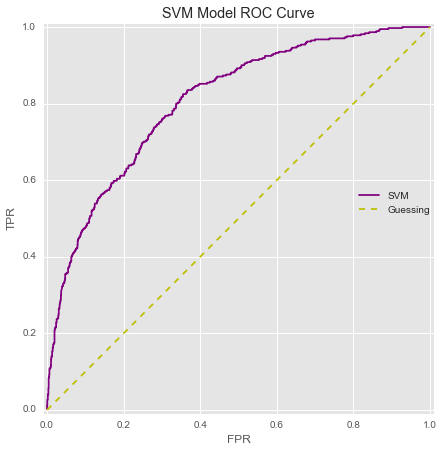

In [66]:
plotROC([[y_test, y_proba, 'purple', 'SVM']], 'SVM Model ROC Curve')